### Week 14 Homework: Multiple Linear and Logistic Regression

**1) Perform pre-processing on the full dataset here: https://www.kaggle.com/sohier/calcofi**

In [2]:
#importing all the usual things

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import plotly.express as px
from scipy import signal

#loading the data as a dataframe
df_bottle = pd.read_csv('bottle.csv')
df_cast = pd.read_csv('cast.csv')

#looking at the bottle dataframe
df_bottle.head()

/Users/jenniferarbuszewski/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (47,73) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/jenniferarbuszewski/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (40,41,44,45,46,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Preprocessing:** Removing columns with too much missing data

In [3]:

#looking at how many NaNs are present in each column
print((df_bottle.isna().sum())/len(df_bottle)*100)

#removing columns with more than 75% data missing as they are unlikely to contribute in a meaningful way
#to the linear regression model in the following questions.
to_drop=[]
for col in df_bottle.columns:
    if ((df_bottle[col].isna().sum())/len(df_bottle[col])*100) > 75.0:
        to_drop.append(col) 
print(to_drop)

#Making a new dataframe without the missing data
df_bottle_less_nan = df_bottle.drop(to_drop, axis=1)
df_bottle_less_nan


#Printing the new dataframe and making sure columns were removed as intended
df_bottle_less_nan.head()
print(len(df_bottle_less_nan.columns))

Cst_Cnt                 0.000000
Btl_Cnt                 0.000000
Sta_ID                  0.000000
Depth_ID                0.000000
Depthm                  0.000000
                         ...    
TA1                    99.759037
TA2                    99.972944
pH2                    99.998844
pH1                    99.990287
DIC Quality Comment    99.993641
Length: 74, dtype: float64
['BtlNum', 'T_qual', 'S_qual', 'O_qual', 'SThtaq', 'NH3uM', 'C14As1', 'C14A1p', 'C14As2', 'C14A2p', 'DarkAs', 'DarkAp', 'MeanAs', 'MeanAp', 'IncTim', 'LightP', 'R_NH4', 'R_SAMP', 'DIC1', 'DIC2', 'TA1', 'TA2', 'pH2', 'pH1', 'DIC Quality Comment']
49


**Preprocessing:** Removing rows with missing T and/or S data

In [4]:
#Dropping rows with NaN values for the T and S columns
df_no_nan = df_bottle_less_nan.dropna(subset = ["T_degC", "Salnty"])


#Printing the shape of the original and edited datasets
print(df_bottle.shape)
print(df_no_nan.shape)

(864863, 74)
(814247, 49)


**Preprocessing:** Removing derived variables, station and depth ID (important to know somewhere but not for what we are trying to do here), raw variables, and variables unrelated to T (the quantity we wish to predict) such as S_prec, T_prec,...

In [5]:
df_preprocessed = df_no_nan.drop(["Cst_Cnt", "Btl_Cnt", "STheta", "O2Sat", "O2ml_L", "RecInd", "P_qual", "O2Satq", "Phaqua", "PO4q", "SiO3qu", "NO2q", "NO3q","C14A1q", "C14A2q", "MeanAq", "R_Depth", "R_TEMP", "R_POTEMP", "R_SALINITY", "R_SIGMA", "R_O2", "R_O2Sat", "R_SIO3", "R_PO4", "R_NO3", "R_NO2", "R_CHLA", "R_PHAEO", "R_PRES", "R_SVA", "R_DYNHT", "Chlqua", "T_prec", "S_prec", "Sta_ID", "DarkAq", "Depth_ID", "NH3q"], axis=1)

print(df_preprocessed.shape)

(814247, 10)


**Preprocessing:** Considering and removing outliers

Many oceanographic parameters vary with depth. Moving from the mixed layer through the thermocline and into deeper regions will likely see different relationships. By taking out outliers in terms of depth, we should be able to achieve a more representative model. 

Index(['Depthm', 'T_degC', 'Salnty', 'Oxy_µmol/Kg', 'ChlorA', 'Phaeop',
       'PO4uM', 'SiO3uM', 'NO2uM', 'NO3uM'],
      dtype='object')


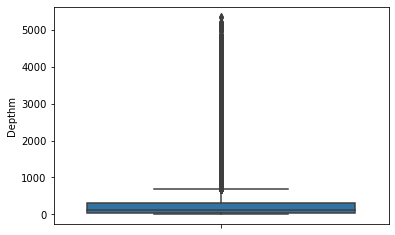

In [7]:
print(df_preprocessed.columns)
import seaborn as sns
ax = sns.boxplot(y="Depthm", data=df_preprocessed)

In [12]:
Q1_depth = np.quantile(df_preprocessed['Depthm'], .25)
Q3_depth = np.quantile(df_preprocessed['Depthm'], .75)
IQR_depth = Q3_depth - Q1_depth
max_outlier = Q3_depth + 1.5 * IQR_depth

print("Q1 quantile of Depth : ", Q1_depth)
print("Q3 quantile of Depth : ", Q3_depth)
print('max depth outlier: ', max_outlier)

Q1 quantile of Depth :  46.0
Q3 quantile of Depth :  300.0
max depth outlier:  681.0


In [15]:
# Removing all rows with a depth of greater than 681m. There are likely better ways to do this including
#considering the depth of the mixed layer where the data/samples were collected. For our purposes, this will suffice.
df_preprocessed2 = df_preprocessed [df_preprocessed['Depthm'] < max_outlier]

df_preprocessed2.head()

,Depthm,T_degC,Salnty,Oxy_µmol/Kg,ChlorA,Phaeop,PO4uM,SiO3uM,NO2uM,NO3uM
0,0,10.50,33.440,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,10.46,33.440,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,10.46,33.437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19,10.45,33.420,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20,10.45,33.421,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Preprocessing:** Normalizing the data where indicated

**2) Perform feature selection (decide what columns should be included in your analysis). How did you figure out what features were important?**

In [17]:
df_preprocessed2.columns


Index(['Depthm', 'T_degC', 'Salnty', 'Oxy_µmol/Kg', 'ChlorA', 'Phaeop',
       'PO4uM', 'SiO3uM', 'NO2uM', 'NO3uM'],
      dtype='object')

In [18]:
#Removing rows with missing data for remainder of columns
df_preprocessed3 = df_preprocessed2.dropna(subset = ["Depthm", "Oxy_µmol/Kg", "ChlorA", "Phaeop", "PO4uM", "SiO3uM", "NO2uM", "NO3uM"])


In [7]:
#Import the modules needed to perform the RFE, SVR, and multivariate linear regression

from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [ ]:
#Set the estimator to linear
#estimator = SVR(kernel="linear")

#Loop through n values for each column other than X1 to optimize the prediction model 
#for n in range(1,10):
  #  print(n)
  #  X = df_preprocessed2.drop(['T_degC'], axis=1)
  #  y = df_preprocessed2['T_degC']
  #  selector = RFE(estimator, n_features_to_select=n, step=1)
   # selector = selector.fit(X, y)
    
    #print out value of n, booleans, and selector rankings for each value of n
   # print(n)
   # print("Selector Support for:", selector.support_)
   # ranking = selector.ranking_
   # print("Selector Ranking", ranking)
    
    #initialize a list
   # selected = []

    
    #Check each index in the selector ranking to see if it should be included in the multivariate linear regression
   # if ranking[0] == 1:
     #   selected.append('Depthm')
    #if ranking[1] == 1:
      #  selected.append('Salnty')
    #if ranking[2] == 1:
     #   selected.append('Oxy_µmol/Kg')
   # if ranking[3] == 1:
      #  selected.append('ChlorA')
    #if ranking[4] == 1:
        #selected.append('Phaeop')
   # if ranking[5] == 1:
       # selected.append('PO4uM')
    #if ranking[6] == 1:
      #  selected.append('SiO3uM')
    #if ranking[7] == 1:
       # selected.append('NO2uM')
   # if ranking[8] == 1:
       # selected.append('NO3uM')


        
    #Print list to check that everything is working as expected
   # print(selected)
    
    #Set new X value to include the selected columns from the RFE above
    #Xi = df_preprocessed2[selected]
    
    #Y value doesn't change; we still want to consider the prediction of X1 column
   # Y = df_preprocessed2['T_degC']
    
    #Perform multivariate linear regression based on results from above, including printing accuracy score and 
    #regression coefficients for each iteration
   # regression = LinearRegression()
   # regression.fit(Xi,y)
   # y_pred = regression.predict(Xi)
   # accuracy_score = regression.score(Xi, y)
   # print("accuracy score:", accuracy_score)
   # print("regression coefficients:", regression.coef_)

1


        Depthm   Salnty  Oxy_µmol/Kg  ChlorA  Phaeop  PO4uM  SiO3uM  NO2uM  \
853254       0  33.3622     228.7400   0.074   0.013   0.29    1.76  0.008   
839162      75  33.3436     209.8474   0.106   0.091   1.08   10.76  0.030   
743270     131  33.2840     229.9337   0.100   0.120   0.95    9.50  0.010   
769888      85  33.3120     185.0918   0.100   0.140   1.33   12.30  0.010   
843894     121  33.6421     162.7588   0.015   0.020   1.60   20.36  0.021   
...        ...      ...          ...     ...     ...    ...     ...    ...   
730253      59  33.4260     256.6351   0.290   0.180   0.37    2.50  0.060   
702437     199  33.9990     104.8599   0.000   0.040   2.19   35.20  0.020   
748018      20  33.5910     249.1764   3.220   0.840   0.70    5.00  0.220   
770672      20  33.3770     262.6900   3.810   1.070   0.60    3.60  0.080   
733319      31  33.6640     239.6685   0.870   0.310   0.55    5.60  0.060   

        NO3uM  
853254   0.02  
839162  11.90  
743270   9.70  

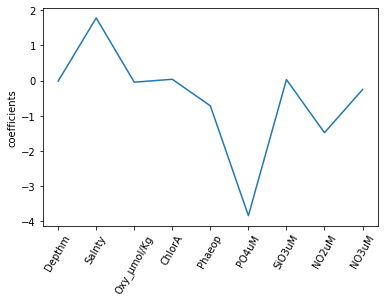

0.25
0.8649478902350846


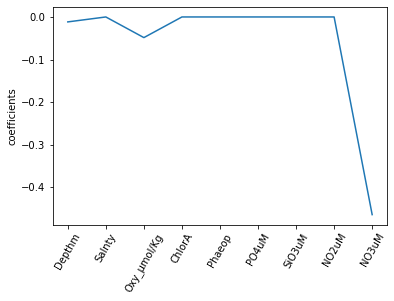

0.5
0.8614928203050032


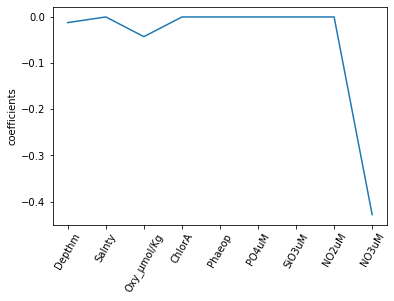

0.75
0.8558401738938829


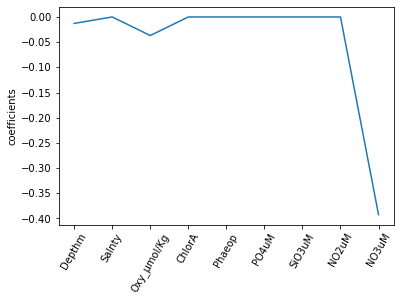

1
0.8478663470756111


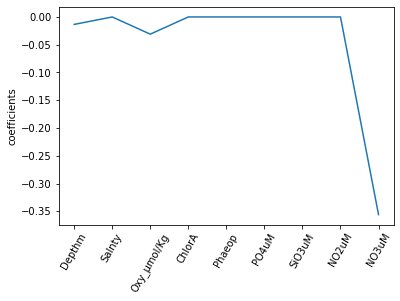

3
0.7631862050822882


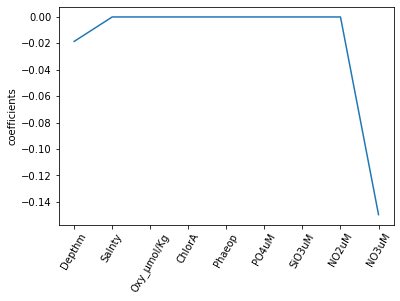

5
0.6562513136602035


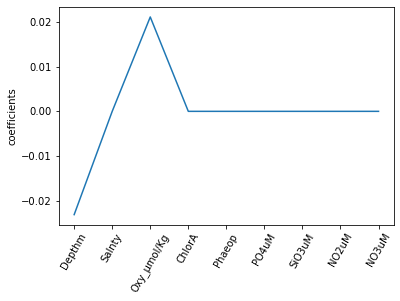

accuracy, alpha value 0.6562513136602035 0


In [19]:
from sklearn.linear_model import Lasso
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df_preprocessed3.drop(['T_degC'], axis=1)

y = df_preprocessed3['T_degC']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
print(X_train)

alpha=0
score=0

#for n in np.arange(0.1, , 0.05):

for n in [0.001, 0.25, 0.5, 0.75, 1, 3, 5]:
    print(n)
    lasso = Lasso(alpha=n)
    lasso.fit(X_train, y_train)
    lasso_pred=lasso.predict(X_test)
    lasso_score=lasso.score(X_test, y_test)
    print(lasso_score)
    
    names=df_preprocessed3.drop('T_degC', axis=1).columns
    lasso_coef=lasso.fit(X_test,y_test).coef_
    lasso_plot=plt.plot(range(len(names)),lasso_coef)
    lasso_ticks=plt.xticks(range(len(names)), names, rotation=60)
    lasso_label=plt.ylabel('coefficients')
    plt.show()

   # if lasso_score>score:
      #  score=lasso_score
      #  alpha=n
print('accuracy, alpha value', lasso_score, alpha)

**Feature selections:**

I used both RFE and attempted to use a Lasso regression to identify the most important features. I realized that my understanding of the Lasso regression is truly not in depth enough to use it for feature selection at this time. In the end, I primarily focused on features that appeared to be independent and made sure that I had eliminated any derived variables. 

**3) Perform multiple linear regression on the dataset. Be sure to display the final resulting equation with the coefficients and intercept in markdown.**

In [20]:
from statsmodels.formula.api import ols

T_multi1 = ols("T_degC ~ Salnty + PO4uM ", data=df_preprocessed3).fit()
print(T_multi1.params)
Salinity_intercept, PO4uM_intercept, slope = T_multi1.params

print('r^2:', T_multi1.rsquared)
print('r^2 adjusted:', T_multi1.rsquared_adj)


Intercept   -84.715820
Salnty        3.058414
PO4uM        -5.047110
dtype: float64
r^2: 0.8174468787827753
r^2 adjusted: 0.8174451153848877


In [21]:
T_multi2 = ols("T_degC ~ Salnty + PO4uM + Depthm ", data=df_preprocessed3).fit()
print(T_multi2.params)
Salinity_intercept, PO4uM_intercept, Depthm_intercept, slope = T_multi2.params

print('r^2:', T_multi2.rsquared)
print('r^2 adjusted:', T_multi2.rsquared_adj)


Intercept   -87.722169
Salnty        3.151989
PO4uM        -4.300920
Depthm       -0.011576
dtype: float64
r^2: 0.8361813271751278
r^2 adjusted: 0.8361789535189428


In [22]:
T_multi3 = ols("T_degC ~ Salnty + PO4uM + Phaeop ", data=df_preprocessed3).fit()
print(T_multi3.params)
Salinity_intercept, PO4uM_intercept, Depthm_intercept, slope = T_multi3.params

print('r^2:', T_multi3.rsquared)
print('r^2 adjusted:', T_multi3.rsquared_adj)

Intercept   -85.796027
Salnty        3.098091
PO4uM        -5.099236
Phaeop       -1.062029
dtype: float64
r^2: 0.826753837011519
r^2 adjusted: 0.8267513267553974


In [23]:
#Previous result showed a decrease in r^2 by including Phaeop so I will leave it out moving forward
T_multi4 = ols("T_degC ~ Salnty + PO4uM + NO2uM ", data=df_preprocessed3).fit()
print(T_multi4.params)

Salinity_intercept, PO4uM_intercept, Depthm_intercept, slope = T_multi4.params

print('r^2:', T_multi4.rsquared)
print('r^2 adjusted:', T_multi4.rsquared_adj)

Intercept   -80.458234
Salnty        2.933850
PO4uM        -5.002700
NO2uM        -2.292180
dtype: float64
r^2: 0.822832441472543
r^2 adjusted: 0.8228298743972284


In [24]:
#Inclusion of NO2uM also showed a decrease in predictive capabilities, so it will be left out moving forward
T_multi5 = ols("T_degC ~ Salnty + PO4uM + NO3uM ", data=df_preprocessed3).fit()
print(T_multi5.params)
Salinity_intercept, PO4uM_intercept, Depthm_intercept, slope = T_multi5.params

print('r^2:', T_multi5.rsquared)
print('r^2 adjusted:', T_multi5.rsquared_adj)

Intercept   -96.119124
Salnty        3.373250
PO4uM        -2.216613
NO3uM        -0.192556
dtype: float64
r^2: 0.8234472559858601
r^2 adjusted: 0.8234446978189212


In [25]:
#Inclusion of NO3uM led to a decrease in predictive capabilities so it will be left out moving forward
T_multi6 = ols("T_degC ~ Salnty + PO4uM + Oxy_µmol/Kg", data=df_preprocessed3).fit()
print(T_multi6.params)
Salinity_intercept, PO4uM_intercept, Depthm_intercept, slope = T_multi6.params

print('r^2:', T_multi6.rsquared)
print('r^2 adjusted:', T_multi6.rsquared_adj)

PatsyError: Error evaluating factor: NameError: name 'Oxy_μmol' is not defined
    T_degC ~ Salnty + PO4uM + Oxy_µmol/Kg
                              ^^^^^^^^

In [26]:
T_multi7 = ols("T_degC ~ Salnty + PO4uM + Depthm", data=df_preprocessed3).fit()
print(T_multi7.params)
Salinity_intercept, PO4_intercept, Depthm_intercept, slope = T_multi7.params

print('r^2:', T_multi7.rsquared)
print('r^2 adjusted:', T_multi7.rsquared_adj)

Intercept   -87.722169
Salnty        3.151989
PO4uM        -4.300920
Depthm       -0.011576
dtype: float64
r^2: 0.8361813271751278
r^2 adjusted: 0.8361789535189428


In [28]:
T_multi8 = ols("T_degC ~ Salnty + Depthm", data=df_preprocessed3).fit()
print(T_multi8.params)
Salinity_intercept, Depthm_intercept, slope = T_multi8.params

print('r^2:', T_multi8.rsquared)
print('r^2 adjusted:', T_multi8.rsquared_adj)

Intercept    46.220970
Salnty       -0.912028
Depthm       -0.037694
dtype: float64
r^2: 0.5925423564967718
r^2 adjusted: 0.5925384206016031


**4) Which regression approach had the “best” performance? Be sure to compare it to what you did last week.**

The multivariate regressions performed significantly better. The r^2 values from last week were pretty low (~0.32) whereas the values from the multivariate regression performed this week resulted in a peak r^2 value of about 0.84 using depth, salinity, and phosphate as predictor features for water temperature.

**Formula:**

Temperature = 3.152989 * Salinity -4.300920 * PO4 - 0.011576 * Depth - 87.722169

**5) Work with the diabetes dataset to perform multiple logistic regression. Look at the documentation for logistic regression in statsmodel and/or sklearn and see if you can tune the model performance based on available parameters. Please note: data scientists need to constantly learn new approaches to optimizing models. This is one way of doing that.** 



In [43]:
#loading the data as a dataframe
df_diabetes = pd.read_csv('diabetes.csv')

df_diabetes.head(3)

df_diabetes.describe

print(df_diabetes.isna().sum())

print(df_diabetes.columns)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


**Multiple Logistic Regression**

In [57]:
# import the class
#from sklearn.linear_model import LogisticRegression

#Setting up the test and training dataset
#X = df_diabetes.drop(['Outcome'], axis=1)
#y = df_diabetes['Outcome']
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
#print(len(X_train), len(y_train))


# instantiating the model 
#logreg = LogisticRegression()

#Fitting the model to the training datset
#logreg.fit(X_train,y_train)
#model = LogisticRegression(random_state=7).fit(X_train, y_train)
#preds = model1.predict(X_test)


#Getting predictions from the test dataset
#y_pred=logreg.predict(X_test)

0.3489583333333333
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



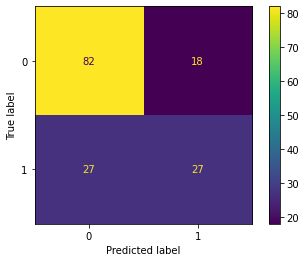

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_diabetes.drop('Outcome', axis=1)
y = df_diabetes['Outcome']

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

#Standardize
sc= StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

#Simplest logistic regression approach
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
sample_pred=[[6,148,72,35,0,33.6,0.627,50]]
y_predicted = clf.predict(X_test)

print(clf.score(X,y))

import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

print(classification_report(y_test, y_predicted))

conf_matrix = confusion_matrix(y_test, y_predicted)

plot_confusion_matrix(clf, X_test, y_test)  
plt.show() 

0.3489583333333333
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       100
           1       0.60      0.72      0.66        54

    accuracy                           0.73       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



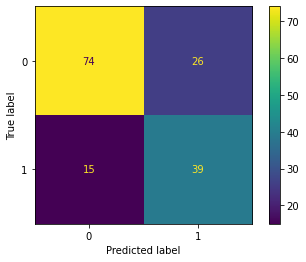

In [69]:


X = df_diabetes.drop('Outcome', axis=1)
y= df_diabetes['Outcome']

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

#Standardize
sc= StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

#Tuning the model to try to improve predictive capabilities:
#Here changing the penalty and class_weight

#Simplest logistic regression approach
clft = LogisticRegression(penalty='l2', C=100, class_weight='balanced', random_state=0).fit(X_train, y_train)
sample_pred=[[6,148,72,35,0,33.6,0.627,50]]
y_predicted = clft.predict(X_test)

#rd = lm.LogisticRegression(penalty='l2', dual=True, tol=0.0001, 
                           #C=1, fit_intercept=True, intercept_scaling=1.0, 
                           #class_weight=None, random_state=None)

print(clf.score(X,y))

import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

print(classification_report(y_test, y_predicted))

conf_matrixt = confusion_matrix(y_test, y_predicted)

plot_confusion_matrix(clft, X_test, y_test)  
plt.show() 

#imposing penalty of l2 does not appear to have any impact nor does changing value to none

**6) What are the other ways to assess the performance of the model besides accuracy? What approach makes the most sense with the diabetes dataset? Why?**



**Confusion Matrix:** identifies array of                    **predicted false** **predicted true**
                                      **actual false** 
                                      **actual true**
                                      
                                      
**Precision:** identifies how often the model makes a correct prediction


**Recall:** identifies how often the positive cases are identified (true positives/(true positives + false negatives))


**F1 Score:** a weighted average of precision and recall with values from 0-1; a score close to 1 is desired


For diabetes, we would likely focus on the recall metric. For a disease, it is important to capture as many positive cases as possible to provide appropriate treatment. Recall is going to give us that.

**7) Is the KNN model or the multiple logistic regression model more performant for the diabetes dataset? How can you tell?**

In [56]:

from sklearn.neighbors import KNeighborsClassifier


diabetes_df = pd.read_csv("diabetes.csv")
# Create feature and target arrays
X = diabetes_df.drop('Outcome', axis=1)
y = diabetes_df['Outcome']
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)
#Standardize
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
# Create a k-NN classifier
knn = KNeighborsClassifier(n_neighbors=12)
# Fit the classifier to the training data
knn.fit(X_train,y_train)
#predict
y_predicted= knn.predict(X_test)
print(y_predicted)
# Print the accuracy
print(knn.score(X_test, y_test))

k=0
score=0

for n in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train,y_train)
    y_predicted= knn.predict(X_test)
    k_score=knn.score(X_test, y_test)
    if k_score>score:
        score=k_score
        k=n
print('accuracy, k value', k_score, k)

from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
print(confusion_matrix(y_test, y_predicted))
print(classification_report(y_test, y_predicted))


[1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0
 1 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0]
0.7727272727272727
accuracy, k value 0.7337662337662337 12
[[88 12]
 [29 25]]
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       100
           1       0.68      0.46      0.55        54

    accuracy                           0.73       154
   macro avg       0.71      0.67      0.68       154
weighted avg       0.73      0.73      0.72       154



The logistic model performs slightly better than the K-nearest neighbors model. This is apparent especially in terms of the precision and recall values, which are the most important indicators of the model's performance for this particular data set.